In [1]:
import pandas as pd
from pulp import *
import numpy as np
np.random.seed(0)

### Parameters
#### Inbound Costs

In [2]:
# Inbound Costs
df_inbound = pd.read_csv('df_inprice.csv', index_col = 0)
df_inbound

,FROM,D1,D2
0,P1,3.0,5.0
1,P2,2.3,6.6


#### Outbound Costs

In [3]:
# Outbound Costs
df_outbound = pd.read_csv('df_outprice.csv', index_col = 0)
df_outbound

,from,S1,S2,S3,S4,S5,S6,S7,S8,S9,...,S191,S192,S193,S194,S195,S196,S197,S198,S199,S200
0,D1,2.30,4.23,2.26,3.38,1.59,2.01,5.32,6.63,2.38,...,5.86,8.30,3.02,1.01,2.77,2.96,3.53,8.60,2.77,7.06
1,D2,5.31,2.18,8.52,8.34,4.59,1.04,1.89,6.45,8.35,...,7.54,2.11,4.33,1.54,4.75,7.84,8.21,4.51,3.27,3.13


In [4]:
# Melting DataFrame
df_melt = pd.melt(df_outbound.set_index('from').T.reset_index(), id_vars=['index'], value_vars=['D1', 'D2'])
print("{:,} records".format(len(df_melt)))
df_melt.head()

400 records


,index,from,value
0,S1,D1,2.30
1,S2,D1,4.23
2,S3,D1,2.26
3,S4,D1,3.38
4,S5,D1,1.59


### Plot Outbound Transportation Costs BoxPlot

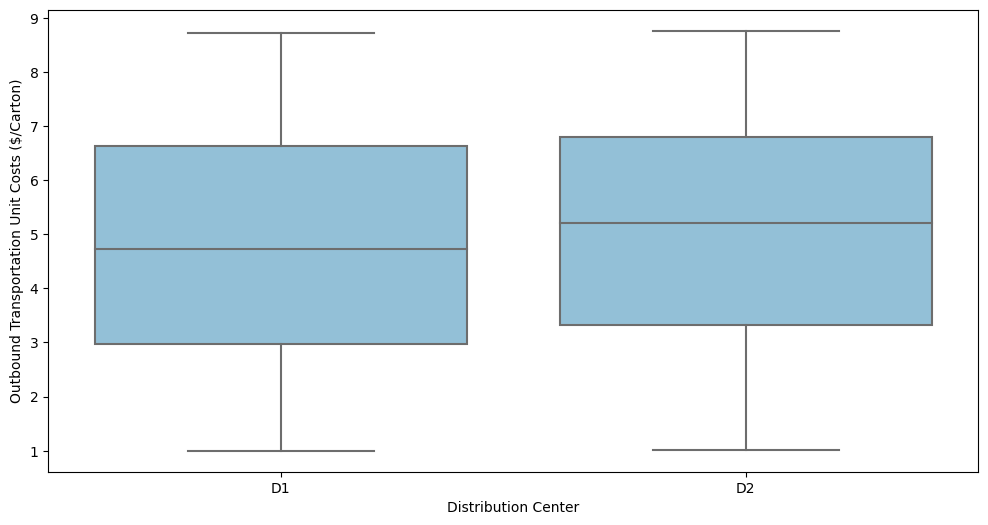

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(12, 6))
ax = sns.boxplot(x='from', y='value', data=df_melt, color='#88c3e2')
#ax = sns.swarmplot(x="from", y="value", data=df_melt, color='#7d0013')
plt.xlabel('Distribution Center')
plt.ylabel('Outbound Transportation Unit Costs ($/Carton)')
plt.show()

### Production Plant Capacity

In [6]:
# Production capacity
PC1 = int(input("Please enter production capacity for Plant 1:\t"))
PC2 = int(input("Please enter production capacity for Plant 2:\t"))
df_prod = pd.DataFrame({
    'plant': ['P1','P2'],
    'max': [PC1, PC2],
})[['plant', 'max']]
df_prod

Please enter production capacity for Plant 1:	200
Please enter production capacity for Plant 2:	300


,plant,max
0,P1,200
1,P2,300


In [7]:
# Cross-Docking Capacity
DC1 = int(input("Please enter Docking capacity for Distribution Center 1:\t"))
DC2 = int(input("Please enter Docking capacity for Distribution Center 2:\t"))
df_t = pd.DataFrame({
    'DC': ['D1','D2'],
    'CAPACITY': [DC1, DC2]
})[['DC', 'CAPACITY']]
df_t

Please enter Docking capacity for Distribution Center 1:	450
Please enter Docking capacity for Distribution Center 2:	200


,DC,CAPACITY
0,D1,450
1,D2,200


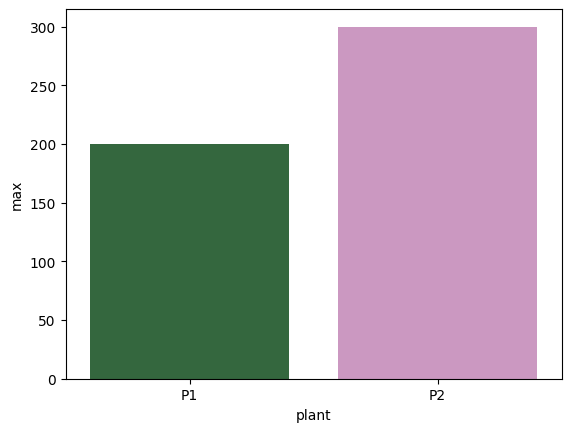

In [32]:
# PLant Production capacity


Pcap = sns.barplot(x='plant' , y ='max',palette="cubehelix", data = df_prod)

plt.show()

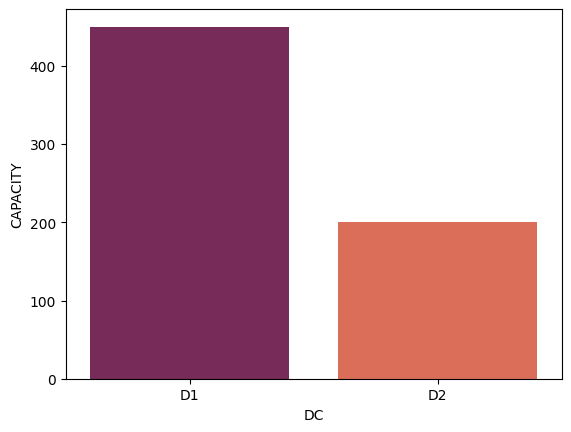

In [31]:
# Distribution Center Docking capacity

Dcap = sns.barplot(x='DC' , y ='CAPACITY',palette="rocket" , data = df_t)
plt.show()

### Demand Data

In [10]:
# Demand
df_demand = pd.read_csv('df_demand.csv', index_col = 0)
print("{:,} total demand".format(df_demand.DEMAND.sum()))
df_demand.head()

31,806 total demand


,STORE,DEMAND
0,D1,244
1,D2,172
2,D3,124
3,D4,90
4,D5,158


### Build the Optimization Model

In [11]:
# 1. Initiliaze Class
model = LpProblem("Transhipment_Problem", LpMinimize)

# 2. Define Decision Variables
# Inbound Flows
I = LpVariable.dicts("I", [(i+1,j+1) for i in range(2) for j in range(2)],
                     lowBound=0, upBound=None, cat='Integer') # I(i,j) from plant i for platform j
# Outbound Flows
O = LpVariable.dicts("O", [(i+1,j+1) for i in range(2) for j in range(200)],
                     lowBound=0, upBound=None, cat='Integer') # O(i,j) from platform i for customer j

# 3. Define Objective Function
# Total Transportation Cost
model += lpSum([df_inbound.iloc[i,j+1] * I[i+1,j+1] for i in range(2) for j in range(2)]) + lpSum([df_outbound.iloc[i,j+1] * O[i+1,j+1] for i in range(2) for j in range(200)]) 


        
    
# Shipment from DCs higher than demand per store
for j in range(200):
    model += lpSum([O[i+1, j+1] for i in range(2)]) >= df_demand.loc[j,'DEMAND']
# Conservation of the flow in the local DC (X-Docking Platform)
for p in range(2):
    model += lpSum([I[i+1, p+1] for i in range(2)]) == lpSum([O[p+1, j+1] for j in range(200)])
    


# Solve Model
status = model.solve()
print(LpStatus[status])
print("Objective: z* = {}".format(
    value(model.objective)))

# Matrix result
inbound, outbound = np.zeros([2,2]), np.zeros([2,200])
for i in range(2):
    for j in range(2):
#         print(I[i+1, j+1].varValue, I[i+1, j+1].name)
        inbound[i, j] = I[i+1, j+1].varValue
for i in range(2):
    for j in range(200):
#         print(O[i+1, j+1].varValue, O[i+1, j+1].name)
        outbound[i, j] = O[i+1, j+1].varValue

Optimal
Objective: z* = 217189.3199999999


### Results

In [12]:
# Inbound flow
df_resin = pd.DataFrame(data = inbound, index =['P' + str(i+1) for i in range(2)], 
                        columns = ['D' + str(i+1) for i in range(2)]).astype(int)
df_resin.to_csv('df_inbound_flow.csv')
df_resin

,D1,D2
P1,0,6232
P2,25574,0


In [13]:
# Outbound flow
df_resout = pd.DataFrame(data = outbound, index =['D' + str(i+1) for i in range(2)], 
                        columns = ['S' + str(i+1) for i in range(200)])
df_resout.to_csv('df_output.csv')
df_resout


,S1,S2,S3,S4,S5,S6,S7,S8,S9,S10,...,S191,S192,S193,S194,S195,S196,S197,S198,S199,S200
D1,244.0,172.0,124.0,90.0,158.0,175.0,0.0,223.0,123.0,0.0,...,250.0,0.0,99.0,178.0,47.0,57.0,52.0,0.0,70.0,0.0
D2,0.0,0.0,0.0,0.0,0.0,0.0,269.0,0.0,0.0,129.0,...,0.0,39.0,0.0,0.0,0.0,0.0,0.0,243.0,0.0,50.0


In [14]:
df_resout.insert(0,'Index',['D1','D2'])
df_resout

,Index,S1,S2,S3,S4,S5,S6,S7,S8,S9,...,S191,S192,S193,S194,S195,S196,S197,S198,S199,S200
D1,D1,244.0,172.0,124.0,90.0,158.0,175.0,0.0,223.0,123.0,...,250.0,0.0,99.0,178.0,47.0,57.0,52.0,0.0,70.0,0.0
D2,D2,0.0,0.0,0.0,0.0,0.0,0.0,269.0,0.0,0.0,...,0.0,39.0,0.0,0.0,0.0,0.0,0.0,243.0,0.0,50.0


In [15]:
#Melt dataframe to sort based on D1 & D2
df_melta = pd.melt(df_resout.set_index('Index').T.reset_index(), id_vars=['index'], value_vars=['D1', 'D2'])
# Filter the zero value rows
df_melta = df_melta[df_melta.value != 0]
df_melta

,index,Index,value
0,S1,D1,244.0
1,S2,D1,172.0
2,S3,D1,124.0
3,S4,D1,90.0
4,S5,D1,158.0
...,...,...,...
366,S167,D2,151.0
388,S189,D2,134.0
391,S192,D2,39.0
397,S198,D2,243.0


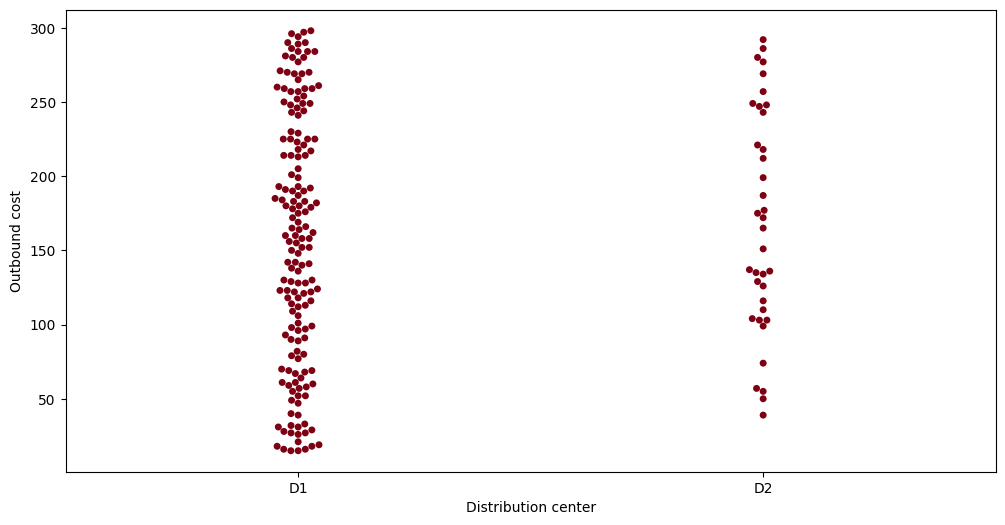

In [16]:
#swarn plot to visualise the distribution centre load
plt.figure(figsize=(12, 6))
ax = sns.swarmplot(x="Index", y="value", data=df_melta, color='#7d0013')
plt.ylabel('Outbound cost')
plt.xlabel('Distribution center')
plt.show()
